In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import collections #---> Library for operating with dictionaries
import random #---> Library for generating random numbers/distributions
import numpy as np #---> Library for efficiently operating with arrays/matrices/vectors
from pylab import rcParams #---> 
from operator import itemgetter 
 
import powerlaw
import seaborn as sns
import matplotlib.colors as mcolors
from itertools import count
import matplotlib.cm as cm
import community
import igraph
from collections import Counter
import matplotlib as mpl
import matplotlib.patches as patches
import random
import time

In [2]:
#Load the Network in a graph G
Gx = nx.read_edgelist('infect-dublin.edges.txt', nodetype=int, create_using=nx.Graph(),data=(('weight',float),))


SIR Model. It has been discovered that the all the infected after a given recovery time became immune. If a node is immune and it is in contact with the infected node it does not became infected, and it will not spread the infection!

Define the function SIR_model() that inputs:

• G (a Network as networkx)

• initial_infected (nodes that are infected at time=0 as list of nodes ID)

• beta (trasmission probability as float)

• t_simulation (simulation iteration time as int)

• recovery_time (the number of days needed for the recovery.)

• nodes that are vaccinated as list of nodes ID.

Output: a dictionary that contains the nodes status at each time steps. In this case the status can be:

• ’S’ as susceptible.

• ’I’ as Infected.

• ’R’ as Recovered.

Using the network Gx and beta=0.005, t_simulation=300, initial_infected=(list of 3 random nodes), recovery_time=15, plot the number of users in each status at each simulation time step.

Second Wave.

After 100 days a second waves of the same infection start to spread on your network. Starting from the day

100: 30 people get infected randomly in your network. Keep fixed the simulation propose by the SIR Model. Randomly add at day 100, 30 new infections. If a person is infected by the second wave this set
of rules applied:

• if the person was ’S’ it became infected.

• if the person was ’I’ you need to set to zero the recovery time (it will have to wait 15 days to became
immune).

• ’R’ remain recovered and it is immune to the second wave.

This new infection is more easy to transmit and it has a beta=0.02!
Please note that if a node is infected with infection 1 and it is still infected it can be infected but infection 2.
If a node is infected with infection 2 it can not be infected with infection 1.

In [3]:
def SIS_model(Gx,beta,t_simulation,initial_infecteds,recovery_time):
    
    #add default status 'S' and counter to -1 to all nodes
    #Counter is to keep track of the number of days of infection
    #wave indicates first wave or second, if node is not infected =-1
    nx.set_node_attributes(Gx, 'S', "Status")
    nx.set_node_attributes(Gx, -1, "counter")
    nx.set_node_attributes(Gx, 0, "wave")
    
    Gx_node=list(Gx.nodes)
    Gx_node.sort()

    #creating an Infection history of all nodes from t=0 to 300
    Infection_history=np.zeros((len(Gx_node),t_simulation+1))

    #update the status of initial infected nodes, infections are of 1st wave
    for i in initial_infecteds:
        Gx.nodes[i]['Status'] = 'I'
        Gx.nodes[i]['counter'] = 0
        Gx.nodes[i]['wave'] = 1
        Infection_history[i-1][0]=1       

    
    for t in range(1,(t_simulation+1)):
        
        #adding new 30 infections on day 100
        if t==100:
            
            possible_candidates=Infection_list=[x for x,y in Gx.nodes(data=True) if y['Status']!='R']
            new_infections=random.sample(possible_candidates, 30)
            
            
            for item in new_infections:
                
                Gx.nodes[item]['Status'] = 'I'
                Gx.nodes[item]['counter'] = 0
                Gx.nodes[item]['wave'] = 2
                Infection_history[item-1][k]=1
                
        i_list=[]
        Infection_list=[x for x,y in Gx.nodes(data=True) if y['Status']=='I']
        
        #for each infected node
        for i in Infection_list:
                        
            #getting the day count of infection
            c=Gx.nodes[i]['counter']
            
            c+=1
            
            #if days less than recovery time it can infect its neighbors else it becomes recovered and is removed
            if c<recovery_time:
                Infection_history[i-1][t]=1
                Gx.nodes[i]['counter'] = c
                
                #find the neighbours of the infected node
                neighbors=list(nx.all_neighbors(Gx,i))
                
                for n in neighbors:
                   
                    if Gx.nodes[n]['Status'] == 'S':
                        #infecting the neighbors with a probability of beta
                        prob=np.random.uniform(0,1)
                        if Gx.nodes[i]['wave']==2:
                            if prob<=0.02:
                                Gx.nodes[n]['Status'] = 'I'
                                Gx.nodes[n]['counter'] = 0
                                Gx.nodes[n]['wave'] = 2
                                i_list.append(n)
                        else:
                            if prob<=beta:
                                Gx.nodes[n]['Status'] = 'I'
                                Gx.nodes[n]['counter'] = 0
                                Gx.nodes[n]['wave'] = 1
                                i_list.append(n)
                        
                    else:
                        continue
            else:
                Gx.nodes[i]['Status'] = 'R'
                Gx.nodes[i]['counter'] = c
                for k in range(t,t_simulation+1):
                    Infection_history[i-1][k]=-1
        
        #updating the history with the new infected nodes 
        for j in i_list:
            Infection_history[j-1][t]=1
        
       
    #creating a dictionary of nodes status at each timestamp
    l=Infection_history.tolist() 
    l1=[]
    for i in range(len(l)):
        l2=[]
        for j in range(len(l[i])):
            if l[i][j]==0:
                l2.append('S')
            if l[i][j]==1:
                l2.append('I')
            if l[i][j]==-1:
                l2.append('R')
        l1.append(l2)
        
    d=zip(Gx_node, l1)
    dic=dict(d)

    return dic

def plot_SIS(x_t,s_t,r_t,t_simulation):
    I=x_t.tolist()
    S=s_t.tolist()
    R=r_t.tolist()
    
    X=[i for i in range(t_simulation+1)]
    plt.figure(figsize = (40,30))
    

    
    plt.plot(X,I,'go',linestyle='solid')
    plt.plot(X,S,'ro',linestyle='solid')
    plt.plot(X,R,'bo',linestyle='solid')
    
    
    plt.xlabel("Simulation time",fontsize=25)  # add X-axis label
    plt.ylabel("No. of users",fontsize=25)  # add Y-axis label
    plt.title("SIS model",fontsize=35)
    plt.legend(["Infected", "Susceptible","Recovered"],fontsize=20)
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)
    plt.show()

Run the Model

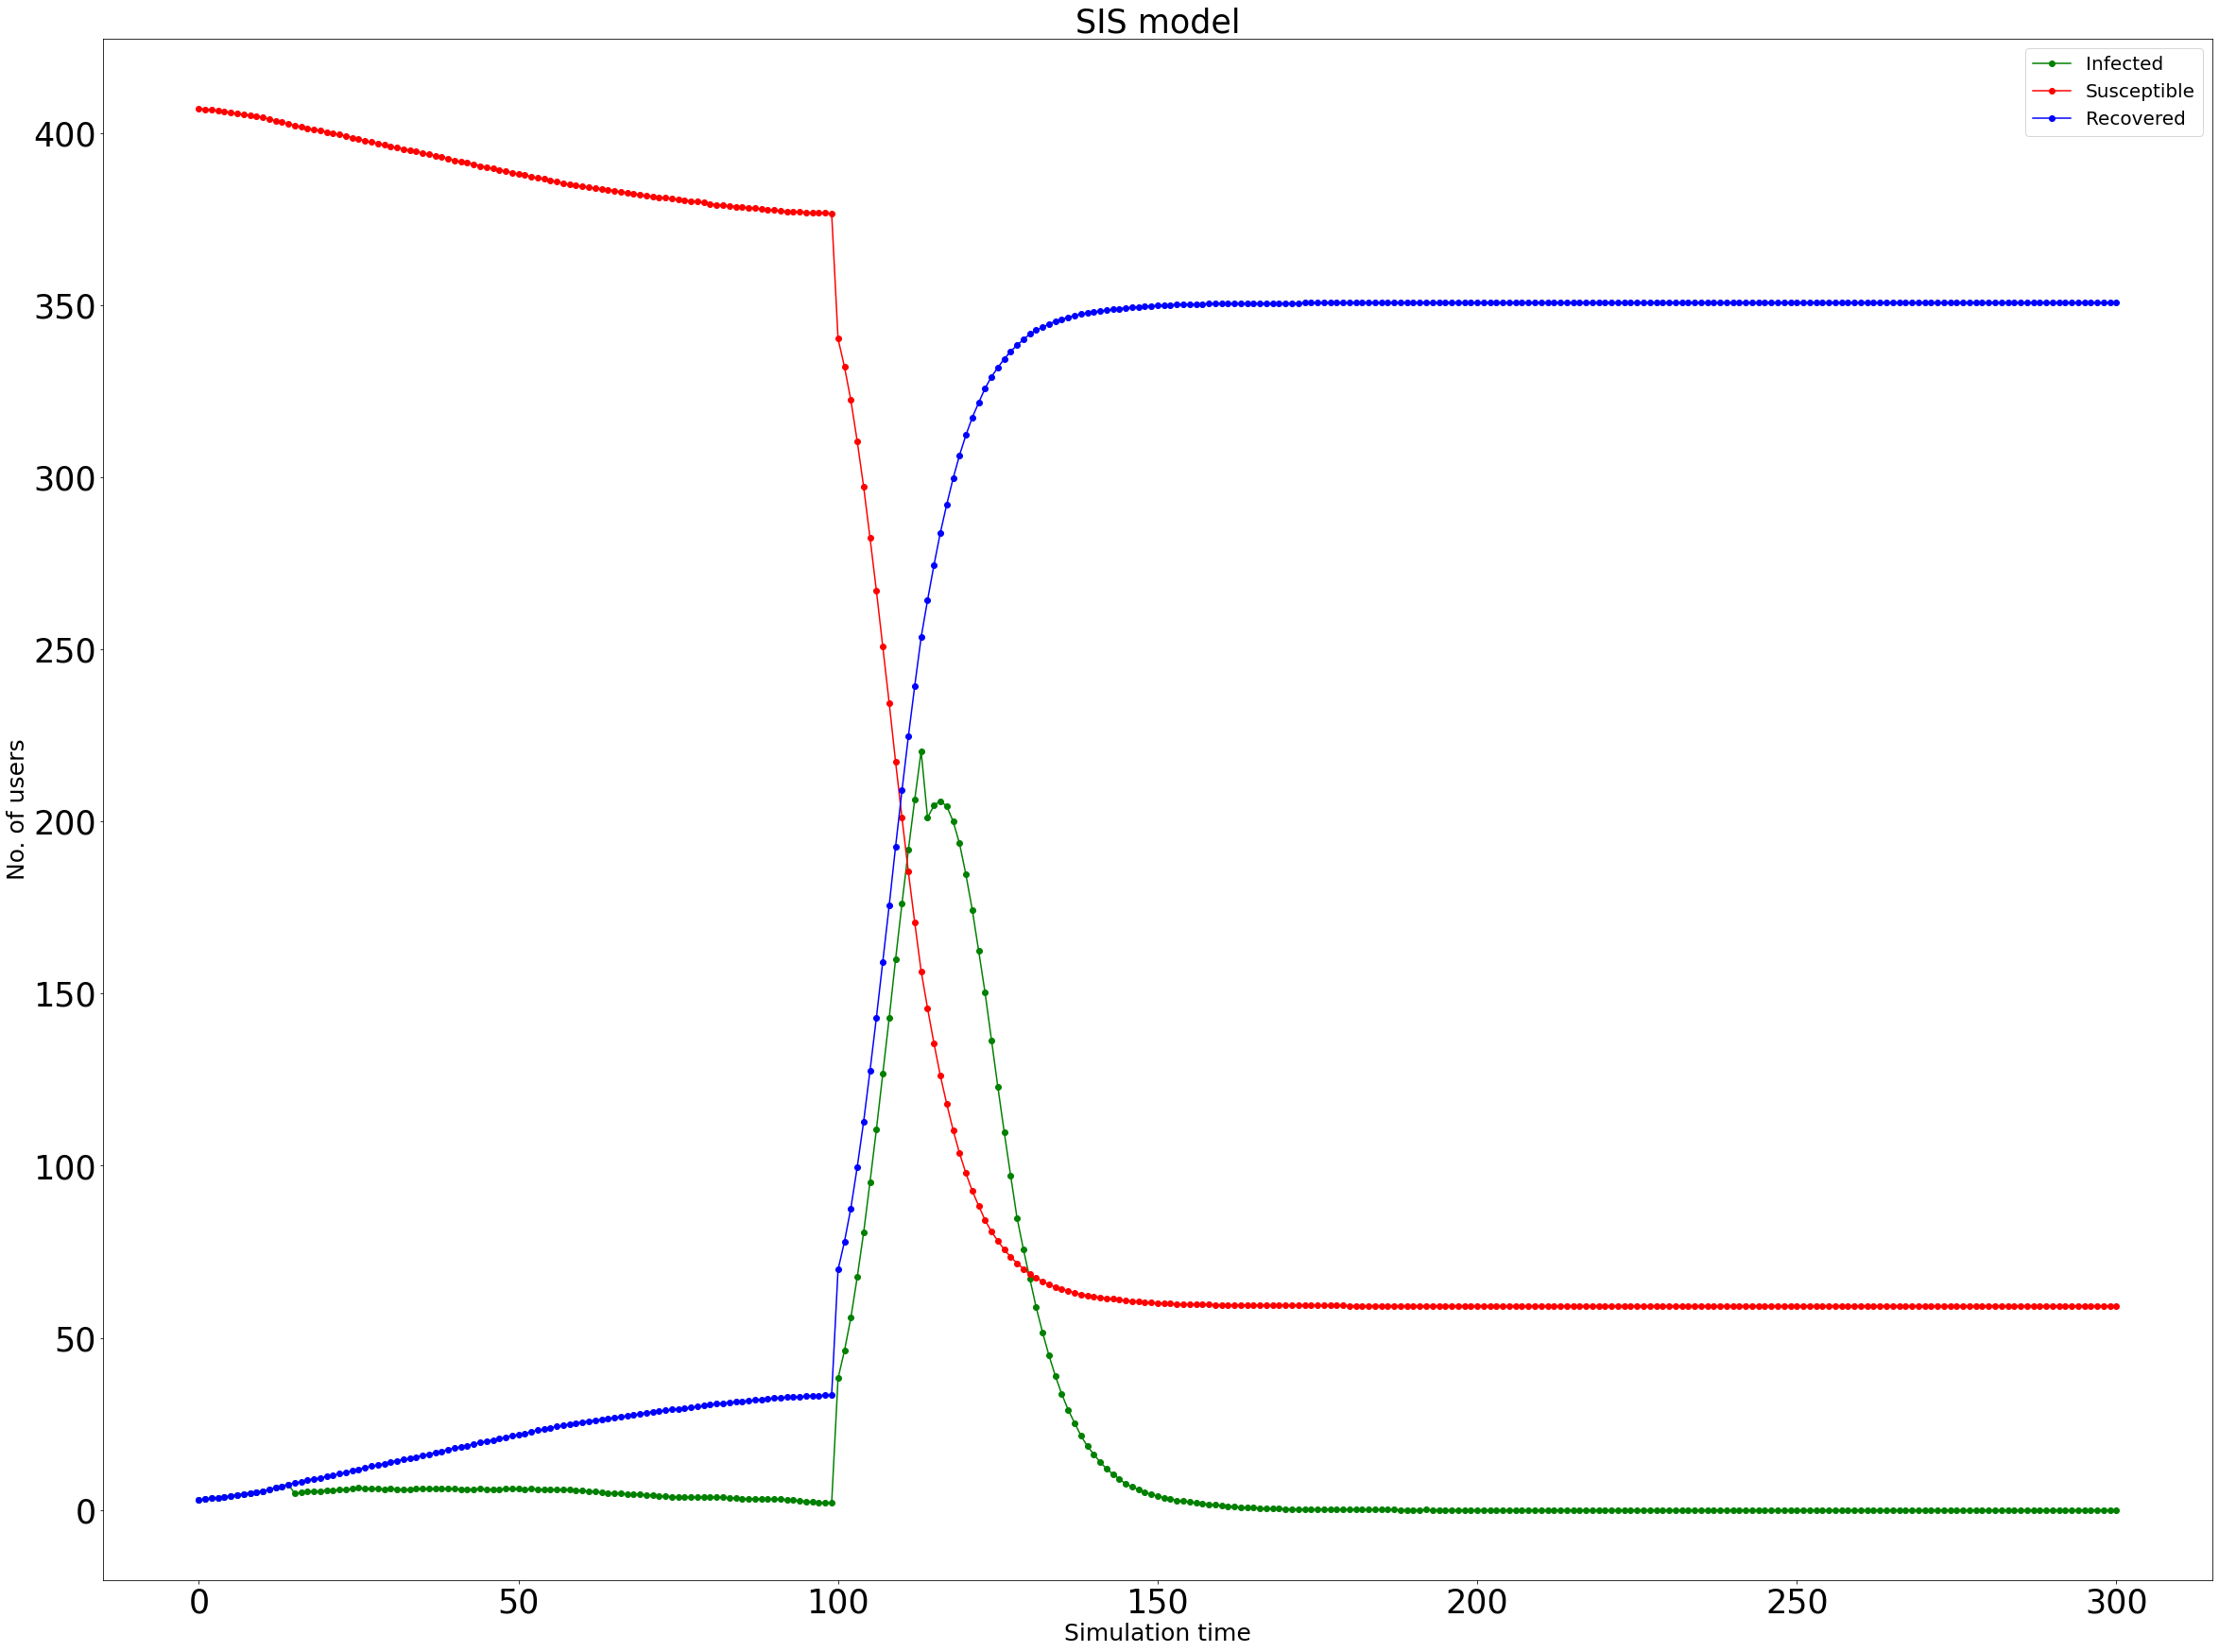

--- 57.59100961685181 seconds ---


In [4]:
beta=0.005
t_simulation=300
initial_infecteds=[100,300,400]  
recovery_time=15

x_n=[]
s_n=[]
r_n=[]

start = time.time()
#100 simulations
for t in range(100):

    Infections_t=SIS_model(Gx,beta,t_simulation,initial_infecteds,recovery_time)
    Infections_val=list(Infections_t.values())
    l1_x=[]
    l1_s=[]
    l1_r=[]
    for j in range(t_simulation+1):
        x_sum=0
        s_sum=0
        r_sum=0
        for i in range(len(Infections_val)):
            if Infections_val[i][j]=='I':
                x_sum+=1
            if Infections_val[i][j]=='S':
                s_sum+=1
            else:
                r_sum+=1
        l1_x.append(x_sum)
        l1_s.append(s_sum)
        l1_r.append(r_sum)
    x_n.append(l1_x)
    s_n.append(l1_s)
    r_n.append(l1_r)

x_n=np.array(x_n)
s_n=np.array(s_n)
r_n=np.array(r_n)
#getting the mean for each day for 100 simulations
x_t2=x_n.mean(axis=0)
s_t2=s_n.mean(axis=0)
r_t2=r_n.mean(axis=0)
#plotting the SIS for 100 simulations
plot_SIS(x_t2,s_t2,r_t2,t_simulation)
            
            

print("--- %s seconds ---" % (time.time() - start))

The above plot shows the status of the nodes i.e. Infected, Susceptible or Recovered for Second Wave. Initially for the first wave the Infection spreads with a probability of 0.005 which is low, on day 100 when 30 new infections of the new variant is introduced there is a spike in infections

Pictorial representation of the simulation

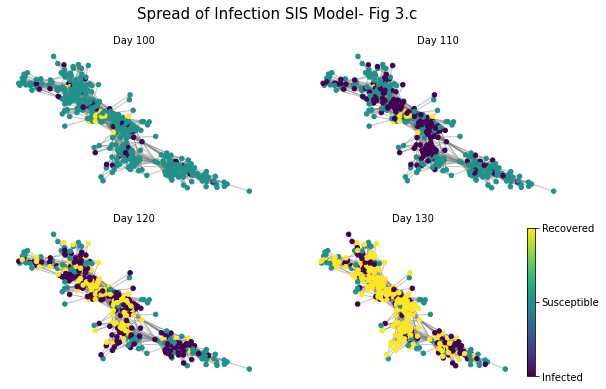

In [5]:
def plot_nodestatus(Gx,node_list,day100,day110,day120,day130):
    
    plt.rcParams["figure.figsize"] = (10,6)
    fig, axes = plt.subplots(nrows=2, ncols=2)
    
    ax = axes.flatten()
    
    
    pos=nx.spring_layout(Gx)
    edge_list=Gx.edges
    norm = mcolors.Normalize(vmin = 0, vmax = 2)
    smp = cm.ScalarMappable(norm=norm, cmap = cm.viridis)
    cbar = plt.colorbar(smp, )
    cbar.set_ticks(range(0, 3))
    cbar.set_ticklabels(["Infected","Susceptible","Recovered"])
    plt.axis('off')
    #plot the 4 chosen days
    nx.draw_networkx_nodes(Gx, pos, nodelist = node_list, node_color = day100, node_size = 20,ax=ax[0])
    nx.draw_networkx_edges(Gx,pos,edgelist=edge_list,edge_color='gray',width=1,alpha=0.5,ax=ax[0])
   
    ax[0].set_title("Day 100",fontsize=10)
    ax[0].set_axis_off()
    
    nx.draw_networkx_nodes(Gx, pos, nodelist = node_list, node_color = day110, node_size = 20,ax=ax[1])
    nx.draw_networkx_edges(Gx,pos,edgelist=edge_list,edge_color='gray',width=1,alpha=0.5,ax=ax[1])
    ax[1].set_title("Day 110",fontsize=10)
    ax[1].set_axis_off()
    
    nx.draw_networkx_nodes(Gx, pos, nodelist = node_list, node_color = day120, node_size = 20,ax=ax[2])
    nx.draw_networkx_edges(Gx,pos,edgelist=edge_list,edge_color='gray',width=1,alpha=0.5,ax=ax[2])
    ax[2].set_title("Day 120",fontsize=10)
    ax[2].set_axis_off()
    
    nx.draw_networkx_nodes(Gx, pos, nodelist = node_list, node_color = day130, node_size = 20,ax=ax[3])
    nx.draw_networkx_edges(Gx,pos,edgelist=edge_list,edge_color='gray',width=1,alpha=0.5,ax=ax[3])
    ax[3].set_title("Day 130",fontsize=10)
    ax[3].set_axis_off()
    
    fig.suptitle("Spread of Infection SIS Model- Fig 3.c",fontsize=15)
    
    plt.show()
    
    
#get the staus of the nodes for chosen days
node_list=list(Infections_t.keys())
infection_hist=list(Infections_t.values())
infection_hist=np.array(infection_hist)

day100=infection_hist[:,100:101].tolist()
day110=infection_hist[:,110:111].tolist()
day120=infection_hist[:,120:121].tolist()
day130=infection_hist[:,130:131].tolist()

day100=[item for sublist in day100 for item in sublist]
day110=[item for sublist in day110 for item in sublist]

day120=[item for sublist in day120 for item in sublist]
day130=[item for sublist in day130 for item in sublist]


color100=[]
color110=[]
color120=[]
color130=[]
#Color the nodes based on the status for each day

for i in range(len(day100)):
    if day100[i]=='I':
        color100.append(0)
        
    if day100[i]=='S':
        color100.append(1)
        
    if day100[i]=='R':
        color100.append(2)
        
        
for i in range(len(day110)):
    if day110[i]=='I':
        color110.append(0)
        
    if day110[i]=='S':
        color110.append(1)
        
    if day110[i]=='R':
        color110.append(2)
        
        
for i in range(len(day120)):
    if day120[i]=='I':
        color120.append(0)
        
    if day120[i]=='S':
        color120.append(1)
        
    if day120[i]=='R':
        color120.append(2)
        
        
for i in range(len(day130)):
    if day130[i]=='I':
        color130.append(0)
    if day130[i]=='S':
        color130.append(1)
    if day130[i]=='R':
        color130.append(2)


    
plot_nodestatus(Gx,node_list,color100,color110,color120,color130)

The above plot shows the spread of infections for second wave. On Day 100 we can see majority of the nodes are susceptible and 30 new infected nodes are introduced, on Day110 the second wave infection spreads but after 15 days the nodes recover by day 130 most of the infected nodes are recovered.